In [269]:
## Import libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd

In [373]:
## Define Basic functions ##

#generate points that aren't too close to each other
def generate_points(minX, maxX, N, dim = 1):
    min_distance = np.abs(maxX-minX)/(2*N)
    print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(minX, maxX, size=(1,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.abs(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
f_scaled = lambda x, minX, maxX: f((maxX - minX)*x+minX) #only if X and not y is scaled


#squared expo kernel
def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
    '''
    
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))
    
    return Xtest, mu, std


#Same as above, but returns sigma instead of std
def posterior_full(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
    '''
    
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)
    
    return Xtest, mu, sigma


#Given test point x (Xtest_val), what is y?
def conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + sigma_n**2*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))

    return Xtest_val, mu, std


#Given test point x (Xtest_val), what is y?
def conditional_full(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + sigma_n**2*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)

    return Xtest_val, mu, sigma


#plot the posterior distribution of GPR
def plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Plot the posterior distribution of GPR
    '''
    #Return mu and std:
    Xtest, mu, std = posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    print("Mean predictive std: ", np.mean(std))
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    plt.plot(Xtest, f_scaled(Xtest,minX,maxX), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()

## Given

Plot of dataset and the function we'd like to estimate (our goal):

0.625


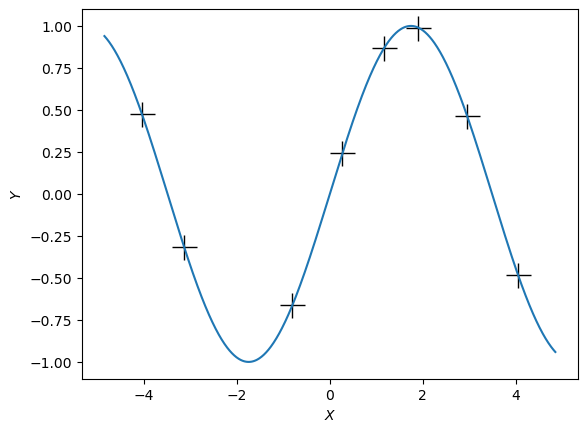

In [959]:
#This is our dataset:
N = 5
X = np.sort(generate_points(-5, 5, N, dim = 1),axis = 0)
y = (f(X) + np.random.normal(0,0,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Plot of data:
plt.plot(X, y, 'k+', ms=18)

#Function we'd like to estimate --> our goal
x = np.arange(min(X)-abs(min(X))*0.2, max(X)+abs(max(X))*0.2, 0.01).reshape(-1,1)

#Render plots
plt.plot(x, f(x))
plt.axis([min(x)-abs(min(x))*0.1, max(x)+abs(max(x))*0.1, min(f(x))-abs(min(f(x)))*0.1,  max(f(x))+abs(max(f(x)))*0.1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

#Normalize feature: X training points, x testing points in between
minX = np.min(X)
maxX = np.max(X)
X = (X - minX)/(maxX - minX) #X in [0,1]

x = x.reshape(-1,1)
x = (x - np.min(x))/(np.max(x) - np.min(x)) #X in [0,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

and we'll use this kernel in our GP:

We use the _Squared Exponential Kernel_, also called Radial Basis Function Kernel or Gaussian Kernel, as our covariance function:
\begin{equation}\label{eq:1}
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
\end{equation}
where the signal variance $\sigma_f^2$ (signal standard deviation $\sigma_f$) and the length scale $l$ are _hyperparameters_ which we'll want to optimize. In this example, this would result in a $n$x$n$ positive-definite covariance matrix $K$ where each element is $\kappa(x_i,x_j)$ with $x_i,x_j$ taken from the $n$ evenly spaced $x$ values for all $i,j\in \{1\ldots,n\}$.

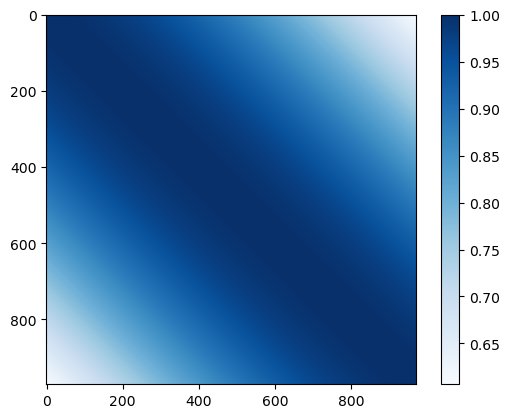

In [960]:
#Plot of kernel
K = kernel(x, x, 1, 1)

plt.imshow(K, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()
plt.show()

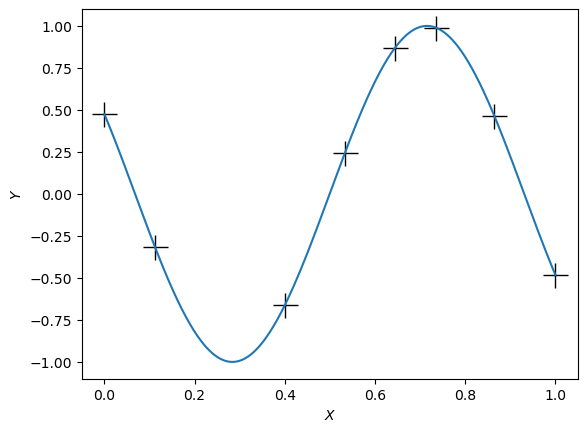

In [961]:
#Plot
plt.plot(X, y, 'k+', ms=18) #data points
plt.plot(x,f_scaled(x,minX,maxX))

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

Initial parameter guesses

In [962]:
#Lengthscale initial guess
def wavelength(X,y):
    '''
    python write a function that iteratively increases the neighborhood size on the x axis
    around the global maximum of y until it finds the smallest y value in a neighborhood
    where the y values are decreasing just before they begin increasing. return the distance
    along the x axis between the global maximum of y and that smallest y value
    '''
    ymax = np.max(y)
    ymax_i = np.argmax(y)
    ymax_x = X[ymax_i]

    loweri = 0
    upperi= len(y)-1

    ysmall_right = ymax
    ysmall_right_i = ymax_i
    i = ymax_i + 1
    while i <= upperi:    
        if y[i-1] >= y[i]: #if left y > right y
            ysmall_right = y[i]
            ysmall_right_i = i
            i = i+1
        else:
            break

    ysmall_left = ymax
    ysmall_left_i = ymax_i
    i = ymax_i - 1    
    while i >= loweri:
        if y[i] <= y[i+1]: #if left y < right y
            ysmall_left = y[i]
            ysmall_left_i = i
            i = i-1
        else:
            break
            
    if ysmall_right<ysmall_left:
        ysmall = ysmall_right
        ysmall_i = ysmall_right_i
    else:
        ysmall = ysmall_left
        ysmall_i = ysmall_left_i
    print(ysmall)
    ysmall_x = X[ysmall_i]
    print(ysmall_x)
    wavelength = 2*np.abs(ymax_x - ysmall_x)
    print(wavelength)
    return wavelength[0]

#Initial guesses#
init_sigma_n = 0.0001 #np.std(y) # guess for observation noise
init_len_scale = wavelength(X,y)
init_sigma_f = np.abs(np.max(y) - np.min(y)) #this is the range of the observations

init_par = [init_sigma_n, init_len_scale, init_sigma_f]
init_par #these are the optimum parameters

[-0.66239829]
[0.39999158]
[0.67000278]


[0.0001, 0.6700027845030215, 1.6520564005346703]

## 5.2 Method 1: Bayesian Model Selection

While there are many variations to model selection, most fall under one of three principles:

1) Find the probability of the model given the data. Ex: Bayesian model selection.

2) Estimate the generalization error. Ex: cross-validation.

3) Bound the generalization error.

The generalization error is the average error on test cases, following the same distribution as the training dataset. We do not aim for low training error since any model may fit the noise in the training set, leading to low training noise but high generalization error, which is an over-fit.

<br><br>
Sources used:
* Rasmussen and Williams, _Gaussian Process for Machine Learning_; pp. 108

The Bayesian view on model selection computes the probability of the model given the data via the marginal likelihood. We use a Bayesian treatment of the parameters as it views any uncertainties (like the parameters, hyperparameters, and models) as random variables with prior distributions.
- It's common practice to use **Bayesian hierarchical modelling**. This is where lowest level are the parameters $w$, like the coefficient parameters in a linear model or the weights in a neural network, the second level are the hyperparameters $\theta$ which determine the distribution of the parameters $w$, like the ''weight decay" term in a neural network or the $\lambda$ term in ridge regression, and the third level may be the set of models, like the choice of kernels.
<br><br>
Bayesian inference (levels 1 to 3):
1. Bayes' rule for the posterior over the parameters: 
$$
p(w\vert y, X, \theta, H_i) = \frac{p(y\vert X, w, H_i)p(w\vert \theta, H_i)}{p(y\vert X, \theta, H_i)}
$$
where $p(y\vert X, w, H_i)$ is the likelihood, $p(w\vert \theta, H_i)$ is the prior, and $p(y\vert X, \theta, H_i)$, which is independent of the parameters, is the marginal likelihood (which we've introduced before):
$$
p(y\vert X, \theta, H_i) = \int p(y\vert X, w, H_i)p(w\vert \theta, H_i) dw
$$
<br><br>
2. Bayes' rule for the posterior over the hyperparameters: here the marginal likelihood from 1. takes the role of the likelihood:
$$
p(\theta\vert y,X,H_i) = \frac{p(y\vert X,\theta,H_i)p(\theta\vert H_i)}{p(y\vert X,H_i)}
$$
where $p(\theta\vert H_i)$ is the hyper-prior (prior distribution for hyperparameters) and the marginal likelihood
$$
p(y\vert X, H_i) = \int p(y\vert X,\theta,H_i)p(\theta\vert H_i) d\theta
$$
3. Bayes' rule for the posterior over the models:
$$
p(H_i\vert y, X) = \frac{p(y\vert X, H_i)p(H_i)}{p(y\vert X)}
$$
where 
$$
p(y\vert X) = \sum_i p(y\vert X,H_i)p(H_i)
$$
<br><br>

The integrals above may or may not be analytically solvable, so in general we must resort other methods like Markov chain Monte Carlo (MCMC).

<br><br>
Sources used:
* Rasmussen and Williams, _Gaussian Process for Machine Learning_; pp. 109

### Exercise

**Exercise:** AME 565 Lab - Maximum Likelihood and Bayesian update

1) Generate $N$ sampes from a normal distribution with mean $1$ and standard deviation $2$. Using maximum likelihood estimation (MLE), find an estimate of the mean and standard deviation. Use an array of value estimates. Start with $N=5$ and increase gradually

2) Consider an exponential distribution of parameter $\lambda = 2$ that we want to estimate based on $N$ observations. First estimate $\lambda$ through MLE. Then use Bayesian update to find a distribution between $1$ and $3$ with standard deviation of $0.5$. In each case, find the maximum of the posterior using an array of $\lambda$ values.

3) Redo 1) and 2) but optimize the MLE

#### 1.

In [117]:
# Given:
N1 = 5
X1 = np.random.normal(1, 2, N1)

We take $N$ samples $X_i\sim N(1,2^2)$. The pdf of $X_i$ is:
$$
f(x_i) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)
$$
We want to estimate the mean $\mu_0$ and variance $\sigma_0^2$ using the MLE.
<br>
The likelihood of these $N$ samples is
$$
L(\mu,\sigma^2\vert x_1,\ldots,x_N) = \prod_{i=1}^N f(x_i) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)
$$
$$
= (2\pi\sigma^2)^{-N/2}\exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^N(x_i-\mu)^2\right)
$$
Taking the log of $L$ gives us the log-likelihood:
$$
l(\mu,\sigma^2\vert x_1,\ldots,x_N) = -\frac{N}{2}\ln(2\pi) - \frac{N}{2}\ln(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^N(x_i-\mu)^2
$$
We find the maximum likelihood estimators by solving the maximization problem $\max_{\mu,\sigma^2} l(\mu,\sigma^2,x_1,\ldots,x_N)$. Taking the partial derivative of the log-likelihood with respect to each parameter, setting each to $0$, and solving returns
$$
\hat{\mu_o} = \frac{1}{N}\sum_{i=1}^N x_i
$$
$$
\hat{\sigma_o^2} = \frac{1}{N}\sum_{i=1}^N(x_i - \hat{\mu_o})^2
$$
We use the last two results to estimate the mean and standard deviation of the given sample:

In [9]:
#N=5
mu_o = (1/N1)*np.sum(X1)
sigma_o = np.sqrt( (1/N)*np.sum((X1-mu_o)**2) )
print(mu_o, sigma_o)

1.1188331825456659 0.9261058699246298


In [10]:
#N=5,...,20
for N1 in range(5,21):
    X1 = np.random.normal(1, 2, N1)
    mu_o = (1/N)*np.sum(X1)
    sigma_o = np.sqrt( (1/N)*np.sum((X1-mu_o)**2) )
    print("N=",N,"mu_0=",mu_o,"sigma_o=",sigma_o)

N= 10 mu_0= 0.4831156058845558 sigma_o= 1.7128175020871315
N= 10 mu_0= 1.47429477290461 sigma_o= 1.7520627761016996
N= 10 mu_0= 0.24403127923031143 sigma_o= 0.6567032368212756
N= 10 mu_0= 1.312666746779362 sigma_o= 2.4170757691467273
N= 10 mu_0= 0.5103603022718052 sigma_o= 1.6783347013226295
N= 10 mu_0= 1.4924999846962046 sigma_o= 1.6797036626559658
N= 10 mu_0= 0.4120262535381609 sigma_o= 2.374127974650998
N= 10 mu_0= 1.6082474691114823 sigma_o= 1.7326532458297546
N= 10 mu_0= 0.37597341489831504 sigma_o= 2.458832685477292
N= 10 mu_0= 1.496660736579576 sigma_o= 2.1957261184241723
N= 10 mu_0= 2.1985385859702196 sigma_o= 2.442192002638882
N= 10 mu_0= 1.754071398698863 sigma_o= 2.5152583362806684
N= 10 mu_0= 2.1119374022812347 sigma_o= 2.3821966490836055
N= 10 mu_0= -0.2981186963607118 sigma_o= 3.5098264390273988
N= 10 mu_0= 2.626774286014105 sigma_o= 3.281616656397202
N= 10 mu_0= 3.574993652467473 sigma_o= 3.6543246930860587


In [11]:
N1 = 10000
X1 = np.random.normal(1, 2, N1)
mu_o = (1/N1)*np.sum(X1)
sigma_o = np.sqrt( (1/N1)*np.sum((X1-mu_o)**2) )
print("N=",N1,"mu_0=",mu_o,"sigma_o=",sigma_o)

N= 10000 mu_0= 0.9902151612844632 sigma_o= 1.9964616443428058


#### 2.

In [12]:
#Given:
N1 = 100
rate = 2 #lambda = 2
X1 = np.random.exponential(1/rate, N1)

We take $N$ samples of $X_i\sim \text{Exp}(\lambda = 2)$. We want to estimate the rate parameter $\lambda_0$. The pdf of $X_i$ is
$$
f(x_i) = \lambda\exp(-\lambda x_i), x_i\in [0,\infty)
$$
The the likelihood is
$$
L(\lambda\vert x_1,\ldots,x_N) = \prod_{i=1}^N f(x_i) = \prod_{i=1}^N \lambda\exp(-\lambda x_i)
$$
$$
= \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
Then the log-likelihood is
$$
l(\lambda\vert x_1,\ldots,x_N) = n\ln(\lambda) - \lambda\sum_{i=1}^N x_i
$$
Taking the partial derivative with respect to $\lambda$, setting it to $0$, and solving yields
$$
\hat{\lambda_o} = \frac{N}{\sum_{i=1}^N x_i}
$$
We use this result to estimate $\lambda_0$:

In [13]:
lambda_o = N/np.sum(X1)
lambda_o

0.18592814668107002

We use a Bayesian update to find a distribution of $\lambda$ (posterior) via (a) uniform prior and (b) truncated normal with std of $0.5$.
<br>
a) The likelihood is a function of $\lambda$ with $X$ fixed was given above as
$$
p(X\vert \lambda) = \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
The prior is $p(\lambda) = \frac{1}{2}, \lambda\in [1,3]$. 
<br>
Then the posterior probability is the probability of $\lambda$ given the $X$:
$$
p(\lambda\vert X) = \frac{p(X\vert\lambda)p(\lambda)}{\int p(X\vert\lambda)p(\lambda)d\lambda}
$$
$$
= \frac{\lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)}{\int_1^3 \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)d\lambda}
$$

In [14]:
#a)
import scipy.integrate as integrate

def integrand1(lam): #denominator & numerator
    return lam**N1 * np.exp(-lam*np.sum(X1))
denom1 = integrate.quad(integrand1, 1, 3)

def post1(lam): #this is the posterior
    return integrand1(lam)/denom1[0]

In [15]:
#double checking that our posterior integrates to 1
integrate.quad(post1,1,3)[0]

0.9999999987581564

In [16]:
obj_list = []
lam_list = []
for lam in np.linspace(1,3,100):
    obj_list.append(post1(lam))
    lam_list.append(lam)

lam_list[np.argmax(obj_list)]

1.8686868686868687

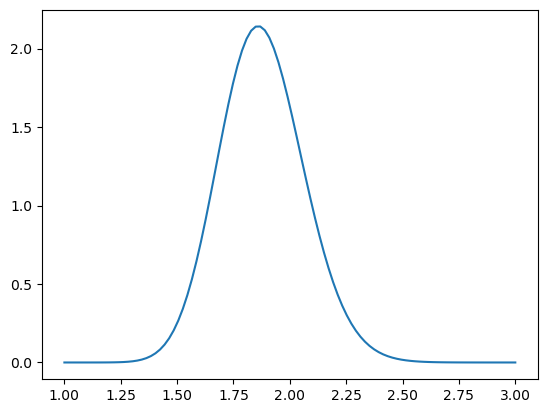

In [17]:
plt.plot(lam_list,obj_list)

b) The likelihood is a function of $\lambda$ with $X$ fixed was given above as
$$
p(X\vert \lambda) = \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
The prior is $p(\lambda) = \text{Norm}(\lambda,0.5), \lambda\in [1,3]$. 
<br>
Then the posterior probability is the probability of $\lambda$ given the $X$:
$$
p(\lambda\vert X) = \frac{p(X\vert\lambda)p(\lambda)}{\int p(X\vert\lambda)p(\lambda)d\lambda}
$$
$$
= \frac{\lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)\text{Norm}(\lambda,0.5)}{\int_1^3 \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)\text{Norm}(\lambda,0.5)d\lambda}
$$

In [18]:
#b)
def integrand2(lam): #denominator & numerator
    return lam**N1 * np.exp(-lam*np.sum(X1)) * stats.norm.pdf(lam,3,0.5)
denom2 = integrate.quad(integrand2, 1, 5) #denominator

def post2(lam): #this is the posterior
    return integrand2(lam)/denom2[0]

In [19]:
#double checking that our posterior integrates to 1
integrate.quad(post2,1,3)[0]

0.9999986672372638

In [20]:
obj_list = []
lam_list = []
for lam in np.linspace(1,3,1000):
    obj_list.append(post2(lam))
    lam_list.append(lam)

lam_list[np.argmax(obj_list)]

2.007007007007007

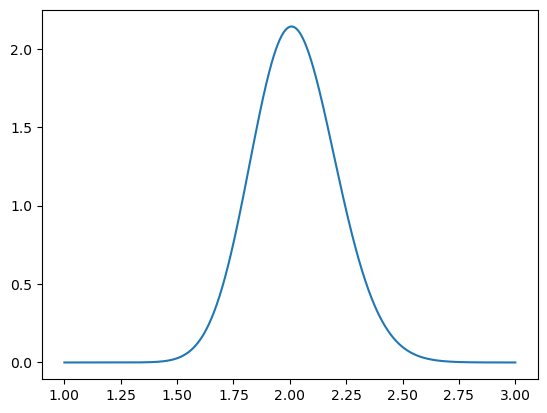

In [21]:
plt.plot(lam_list,obj_list)

#### 3.

In [22]:
#2)
#lets find the maximum of the posterior:
def obj_fun1(lam):
    return -1*post1(lam)
#lets find the maximum of the posterior:
def obj_fun2(lam):
    return -1*post2(lam)
min_a = minimize(obj_fun1, 1.1, method = "Nelder-Mead")
print(min_a)
min_b = minimize(obj_fun2, 1.1, method = "Nelder-Mead")
print(min_b)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -2.143892838399322
             x: [ 1.859e+00]
           nit: 17
          nfev: 34
 final_simplex: (array([[ 1.859e+00],
                       [ 1.859e+00]]), array([-2.144e+00, -2.144e+00]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -2.1419940342412795
             x: [ 2.007e+00]
           nit: 17
          nfev: 34
 final_simplex: (array([[ 2.007e+00],
                       [ 2.008e+00]]), array([-2.142e+00, -2.142e+00]))


## The Problem

From Bayesian hierarchical model, we focus on level 2 for hyperparameter selection:

2. Bayes' rule for the posterior over the hyperparameters: here the marginal likelihood from level 1. takes the role of the likelihood:
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{p(y\vert X)}
$$
where $p(\theta)$ is the hyper-prior (prior distribution for hyperparameters) and the marginal likelihood
$$
p(y\vert X) = \int p(y\vert X,\theta)p(\theta) d\theta
$$
and the likelihood
$$
p(y\vert X,\theta) = \int p(y\vert X, f)p(f\vert \theta) df
$$
is the marginal likelihood in level 1.
<br><br><br>

**Aproach 1: Type II maximum likelihood (we have done before, see Hyperparameter_Kernel_Selection notebook)**

We have $m$ hyperparameters $\theta = (\theta_1,\ldots,\theta_m)$ in our GP model based on observations $(X,y)$, and the covariance function $K$ is a function of $\theta$, so we write the marginal likelihood conditioned on the hyperparameters $\theta$. If our goal is to maximize the marginal likelihood $p(y\vert X,\theta)$ from level 1 with respect to $\theta$, where $\theta$ is unknown and $(X,y)$ is our observed data, then the aproximation is called a _type II maximum likelihood_. That is, we want to find the _maximum marginal likelihood_
$$
\hat{\theta} = \text{argmax}_\theta p(y\vert X,\theta)
$$

Let's write $y\sim N(0,K+\sigma_n^2I) = N(0,K_y)$, where $K = k(X,X)$ and $K_y$ depend on $X,\theta$ (for $K_y$, $\theta$ includes $\sigma_n$). Then,
$$
p(y\vert X,\theta) = (2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y]
$$
which we rewrite as the marginal log-likelihood
$$
\ln(p(y\vert X,\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y.
$$
<br><br><br>

**Approach 2: Integratation**
We would like to find the posterior
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{p(y\vert X)}
$$
<br>
$$
= \frac{p(y\vert X,\theta)p(\theta)}{\int p(y\vert X,\theta)p(\theta) d\theta}
$$
<br>
$$
= \frac{\left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y] \right)p(\theta)}{\int \left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y] \right)p(\theta) d\theta}
$$
<br>
We've already done approach 1 before, so we'll do approach 2. We find the posterior using Markov chain Monte Carlo (MCMC) methods.

## Explanation of MCMC

### Basic Monte Carlo Integration
Before we go into MCMC, let's investigate how to numerically estiamte the integration of a function $f(x)$ using a Monte Carlo method. Our goal is to solve the following integration problem:
$$
F = \int_{x\in D} f(x) dx
$$
We can express this as an expectation problem:
$$
F = \int_{x\in D} \frac{f(x)}{p(x)}p(x)dx = \int_{x\in D} g(x)p(x)dx = E[g(x)] = E\left[\frac{f(x)}{p(x)}\right]
$$
where $p(x)$ is the pdf of our sampling distro (like a proposal distribution in MCMC). We can approximate the integral with a sum:
$$
E[g(x)] \approx \frac{1}{N}\sum_{i=1}^N g(x_i) = \frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{p(x_i)}
$$
By the Strong Law of Large Numbers,
$$
P(\lim_{N\rightarrow\infty}F^N = F) = 1
$$
For example, we're sampling from a 1D uniform distro, then the $N$ uniform variables $X_i\in [a,b)$ with pdf $p(x) = 1/(b-a)$, so
$$
\hat{F^N} = (b-a)\frac{1}{N}\sum_{i=1}^N f(x_i)
$$
While there exists standard integration techniques which converge much faster in one dimension, they suffer from the curse of dimensionality where the convergence rate becomes exponentially worse in higher dimensions. The Monte Carlo estimator is unaffected by the number of dimensions, making it the only practical technique for high dimensional integration problems.
<br><br><br>
Variance of $F^N$:
$$
\text{Var}[\hat{F^N}] = \frac{1}{N}\text{Var}\left[\frac{f(x_i)}{p(x_i)}\right]
$$
How to reduce variance? Try **importance sampling**: choose samples from a distribution $p(x)$ which has a similar shape as $f(x)$. Importance sampling attempts to sample where the contribution of the integrand is high (important).
<br>
1) If $f(x) = g(x)h(x)$,  we can construct a pdf such that $p(x)$ is proportional to $g(x)$:
$$
\frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{p(x_i)} = \frac{1}{N}\sum_{i=1}^N \frac{g(x_i)h(x_i)}{cg(x_i)} = \frac{1}{cN}\sum_{i=1}^N h(x_i)
$$
2) Choose $g(x)$ where its analytical integral is known and $\frac{f(x_i)-g(x_i)}{p(x_i)}$ is close to a constant.
3) Stratified sampling: split the original integral into a sum of integrals over sub-domains (strata). We can split the domain $[a,b]$ into $N$ sub-domains. With a uniform pdf with $\epsilon_i\in[0,1)$, we have
$$
\hat{F^N} = (b-a)\frac{1}{N}\sum_{i=1}^N f\left(a+\frac{i+\epsilon_i}{N}(b-a)\right)
$$

<br><br><br>
Sources used
- https://cs.dartmouth.edu/~wjarosz/publications/dissertation/appendixA.pdf

Coding references
- https://towardsdatascience.com/the-basics-of-monte-carlo-integration-5fe16b40482d
- https://boyangzhao.github.io/posts/monte-carlo-integration

### MCMC
#### 1. Bayesian inference
Why MCMC? It allows us to simulate values from an unknown distro.

Bayesian inference:
- access to observations $y$ in light of underlying data $X$ to make predictions as a function of parameters $\theta$
- $p(y\vert X,\theta)$ is the likelihood of $\theta$ based on $y$

By Bayes theorem
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{\int p(y\vert X,\theta)p(\theta) d\theta}
$$
where
$$
\int p(y\vert X,\theta)p(\theta) d\theta
$$
is the evidence or marginal likelihood because the GP model for $X$ is marginalized (integrated) over all possible parameter values $\theta$.
<br>
Let's rewrite posterior as
$$
P(\theta) = \frac{L(\theta)p(\theta)}{\int L(\theta)p(\theta)d\theta} = \frac{\tilde{P}(\theta)}{\int \tilde{P}(\theta)d\theta} = \frac{\tilde{P}(\theta)}{Z}
$$
where $\tilde{P}(\theta) = ZP(\theta)$ is the unnormalized posterior. Our goal is to find the following:
$$
E_p[f(\theta)] = \frac{\int f(\theta)\tilde{P}(\theta)d\theta}{\int \tilde{P}(\theta)d\theta} = \int f(\theta)P(\theta)d\theta
$$
so we want to use the posterior to propose a point estimate $\hat{\theta}$ for $\theta$.
<br><br><br><br>

#### 2. Estimating integrals using grids
1D case: Riemann sum of $n$ rectangels over discrete grid of points
$$
E_p[f(\theta)] = \int f(\theta)P(\theta)d\theta = \frac{\int f(\theta)\tilde{P}(\theta)d\theta}{\int \tilde{P}(\theta)d\theta} \approx \sum_{i=1}^n f(\theta_i)P(\theta_i)\Delta\theta_i = \frac{\sum_{i=1}^n f(\theta_i)\tilde{P}(\theta_i)\Delta\theta_i}{\sum_{i=1}^n \tilde{P}(\theta_i)\Delta\theta_i}
$$
where $\theta_{i+1}-\theta_i$ and $\theta_i = (\theta_{i+1}+\theta_i)/2$. In ND case with $n$ cuboids, $\Delta\theta_i = \prod_{j=1}^d\Delta_{i,j}$ for the $i$th cuboid in the $j$th dimension.
<br>
Problems:
1) $n$ grid points increases exponentially as dimension $d$ increases, the curse of dimensionality
2) contribution of each portion of grid points uneven, so effectiveness also depends on where the $n$ points are
3) The limit as $N\rightarrow\infty$ of the integral approximation may converge, but only if the grid covers the entire domain of $\theta$ would the grid method be a consistent estimator, which is impossible in practice.

<br>
Solution: MCMC
<br>

For problem 2), we can think of the approximation as a weighted sum:
$$
E_p[f(\theta)] = \frac{\sum_{i=1}^n f(\theta_i)\tilde{P}(\theta_i)\Delta\theta_i}{\sum_{i=1}^n \tilde{P}(\theta_i)\Delta\theta_i} = \frac{\sum_{i=1}^n w_i f(\theta_i)}{\sum_{i=1}^n w_i}
$$
<br>
Our effective sample size (ess), depending on the weights, is $n_{eff}<n$. In theory, $n_{eff} = (\sum w_i)^2/(\sum w_i^2)$
<br><br><br><br>

#### 3. Monte Carlo methods
Goal: estimate $E_p[f(\theta)]$ using a grid of $n$ points to an equivalent estimation of $n$ samples $\{f(\theta_1),\ldots,f(\theta_n)\}$ and associated weights $\{w_1,\ldots,w_n\}$, but we also want to addaptively increase resolution of the grid, that is, adjust $\Delta\theta_i$ such that the weights $w_i = \tilde{P}(\theta_i)\Delta\theta_i$ are uniform to some precision, so we want
$$
\Delta\theta_i \propto \frac{1}{\tilde{P}(\theta_i)}
$$
Let's define the pdf $Q(\theta)$ from some _proposal distribution_ $Q$ based on varying resolution of points $\Delta\theta(\theta)$:
$$
Q(\theta) \propto \frac{1}{\Delta\theta(\theta)}
$$
so
$$
E_p[f(\theta)] = \frac{\int f(\theta)\tilde{P}(\theta)d\theta}{\int \tilde{P}(\theta)d\theta} = \frac{\int f(\theta)\frac{\tilde{P}(\theta)}{Q(\theta)}Q(\theta)d\theta}{\int \frac{\tilde{P}(\theta)}{Q(\theta)}Q(\theta)d\theta} = \frac{E_Q[f(\theta)\tilde{P}(\theta)/Q(\theta)]}{E_Q[\tilde{P}(\theta)/Q(\theta)]}
$$

we do this because we can estimate the expressions using a series of $n$ randomly generated samples from $Q(\theta)$. This is called a Monte Carlo approach for estimating the expectation (see MC Integration method above). Drawing $n$ samples from $\{\theta_1,\ldots,\theta_n\}$ from $Q(\theta)$ is inherently random, a stochastic process. Since the $n$ samples are generated randomly from $Q(\theta)$ over the entire sample space, we can guarantee $Q(\theta)$ will provide sufficient coverage over all possible $\theta$, so Monte Carlo methods are consistent estimators.
<br><br>

(#1): If we let $\tilde{P}(\theta_i)/Q(\theta_i) = \tilde{w}(\theta_i)$,
$$
E_p[f(\theta)] = \frac{E_Q[f(\theta)\tilde{w}(\theta)]}{E_Q[\tilde{w}(\theta)]} \approx \frac{\sum_{i=1}^n f(\theta_i)\tilde{w}(\theta_i)Q(\theta_i)}{\sum_{i=1}^n \tilde{w}(\theta_i)Q(\theta_i)}
$$
<br><br>

If we assume that _proposal distribution_ $Q(\theta)$ has the 1D uniform distribution, then $Q(\theta_i) = 1/n$ and $\tilde{w}(\theta_i) = \tilde{P}(\theta_i)$ so
$$
E_p[f(\theta)] \approx \frac{n^{-1}\sum_{i=1}^n f(\theta_i)\tilde{w}(\theta_i)}{n^{-1}\sum_{i=1}^n \tilde{w}(\theta_i)}
$$
and observe that
$$
Z = \int \tilde{P}(\theta)d\theta \approx \frac{1}{n}\sum_{i=1}^n \tilde{w}(\theta_i)
$$
which is simply a Monte Carlo integral estimate of the evidence in the posterior.
<br><br><br>

The above method in (#1) is called _importance sampling_ where $\tilde{w}(\theta_i)$ are the _importance weights_. Instead of the uniform, we could choose $Q(\theta)=p(\theta)$ the prior.Then $\tilde{w}(\theta_i) = L(\theta_i)$. The optimal strategy would be to use $Q(\theta) = P(\theta)$ so that $\tilde{w}(\theta_i) = Z$ which generates the maximum possible ess of the parameter space. This is the motivation behind MCMC.
<br><br><br><br>

#### 4. Markov Chain Monte Carlo (MCMC) via the Metropolis-Hastings Algorithm
Goal: create a _chain_ of correlated parameter values $\{\theta_1\rightarrow \cdots \rightarrow \theta_n\}$ over $n$ iterations such that the number of iterations $m(\theta_i)$ spent on any region $\delta_{\theta_i}$ centered on $\theta_i$ is proportional to $P(\theta_i)$ contained within $\delta_{\theta_i}$. We want the limiting behavior to reduce to a chain of samples whose distribution follows the posterior.
<br><br>

The _Metropolis-Hastings_ algorithm can draw samples from any probability density $P(\theta)$, which is the posterior in this case, provided that we know $\tilde{P}(\theta)$ which is proportional to $P(\theta)$. At iteration $i$ the method used to propose a candidate $\theta_i$ is by sampling from the proposal distribution $Q(\theta_i\vert \theta_{i-1})$. A common choice for $Q(\theta_i\vert\theta_{i-1})$ is a normal distribution centered at $\theta_{i-1}$, making the chain a _Gaussian random walk_. The algorithm is as follows:

0) Choose an arbitrary starting point $\theta_0$ to be the first observation in the sample. Beginning from iteration $i=1$, choose a symmetric proposal pdf $Q(\theta_i\vert \theta_{i-1})$.

For each iteration $i$,
1) Propose a new position $\theta_{i-1}\rightarrow \theta_i'$ by generating a sample from $Q(\theta_i'\vert \theta_{i-1})$
2) Compute the _transition probability_ (_acceptance ratio_)
$$
\alpha = T(\theta_{i}'\vert\theta_i) = \min\left[\frac{P(\theta_i')Q(\theta_{i-1}\vert \theta_i')}{P(\theta_{i-1})Q(\theta_i'\vert \theta_{i-1})} , 1 \right] = \min\left[\frac{\tilde{P}(\theta_i')Q(\theta_{i-1}\vert \theta_i')}{\tilde{P}(\theta_{i-1})Q(\theta_i'\vert \theta_{i-1})} , 1 \right]
$$
<br>
since $P$ is proportional to $\tilde{P}$. If the proposal distribution $Q$ is symmetric, then the pdfs $Q(\theta_i'\vert \theta_{i-1}) = Q(\theta_{i-1}\vert \theta_i')$ and so
<br>
$$
\alpha = T(\theta_{i}'\vert\theta_i) = \min\left[\frac{\tilde{P}(\theta_i')}{\tilde{P}(\theta_{i-1})} , 1 \right]
$$
3) Generate a random uniform number $u_{i}\sim U(0,1)$.
4) If $u_i\leq \alpha$, accept the proposal by setting $\theta_i = \theta_i'$. Else, reject the proposal and set $\theta_i = \theta_{i-1}$.

<br><br><br>

This method generates a chain of states where the next proposed position depends only on the current position (forgets the past), making it a _Markov process_. Since we must guess $\theta_0$, we remove initial chain of states from the sample once the chain begins to sample from higher probability regions, known as a _burn-in_.

$\theta_i$ is likely to be correlated with $\theta_{i-1}$ and $\theta_{i+1}$. If the acceptance ratio is low, we increase in overall correlation. The auto-covariance $C(t)$ for iteration lag $t$ is
$$
C(t) = \lim_{n\rightarrow\infty}\frac{1}{n}\sum_{i=1}^n(\theta_{i}-\bar{\theta})\cdot(\theta_{i+t}-\bar{\theta})
$$
and the _autocorrelation_ is
$$
A(t) = \frac{C(t)}{C(0)}
$$
with auto-correlation time
$$
\tau = 2\sum_{t=1}^\infty A(t)
$$
and
$$
n_{eff}' = \frac{n_{eff}}{1+\tau}
$$

<br><br><br><br>

Sources
- https://arxiv.org/pdf/1909.12313.pdf

Literature references
- https://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf
- https://arxiv.org/pdf/2304.02595.pdf

Coding references
- https://boyangzhao.github.io/posts/mcmc-bayesian-inference
- https://people.duke.edu/~ccc14/sta-663/MCMC.html
- https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

##### Example 1
Generate $N(0,1)$ using the random walk Metropolis algorithm based on proposal distribution $Q(\theta_i'\vert \theta_{i-1}) \sim \text{Unif}(\theta_{i-1}-a, \theta_{i-1}+a)$.

In [421]:
#0) Initiation
bound = 2 #bounds of theta
a = 1
N = 5000
theta = np.zeros(N)
theta[0] = 0  # first value of theta in the Markov chain is 0.

for i in range(1, N):
    #1) Propose new position theta[i-1] -> theta[i]' by sampling from proposal distro
    theta_prop = np.random.uniform(theta[i-1]-a, theta[i-1]+a) #theta[i]'

    #2) Compute transition probability
    P_prop = stats.norm.pdf(theta_prop, 0, 1) #~P(theta_i')
    P_prev = stats.norm.pdf(theta[i-1], 0, 1)  #~P(theta_{i-1})
    
    alpha = min(P_prop/P_prev, 1)  # Acceptance ratio
    
    #3) Generate a random number u_i from [0,1]
    u = np.random.uniform(0,1) #u_i
    
    #4)
    if (u <= alpha and -bound<= theta_prop <= bound):
        theta[i] = theta_prop  # Accept y as next state
    else:
        theta[i] = theta[i-1]  # Stay at previous state of Markov chain

n = int(0.95*N)
C = theta[-n:]
C

array([-0.48701503, -0.62812788, -0.38414194, ..., -0.17860198,
        0.219007  ,  0.01479825])

Text(0, 0.5, 'Theta')

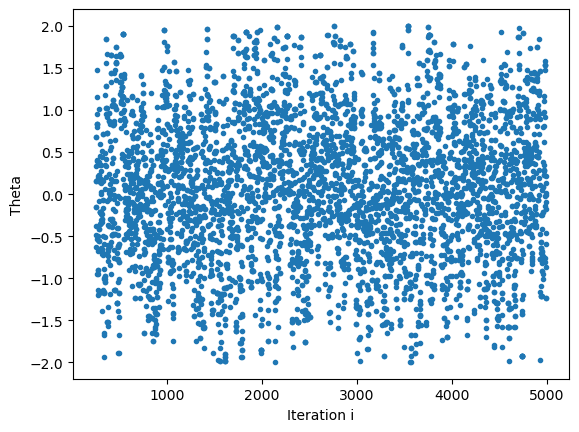

In [422]:
plt.plot(range(N-n, N),C,'.')
plt.xlabel('Iteration i')
plt.ylabel('Theta')

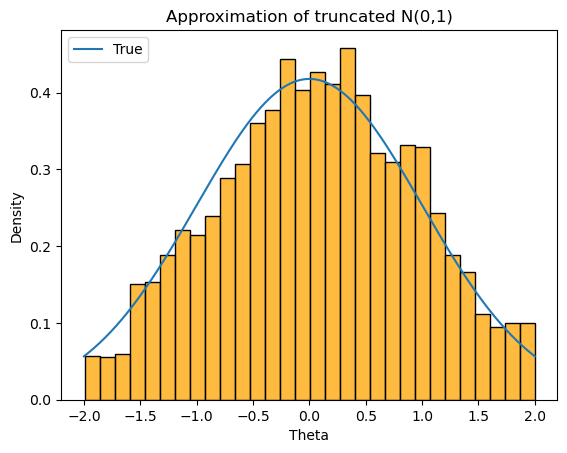

In [423]:
# Plot of true density function
x = np.linspace(-bound,bound,1000)
plt.plot(x, stats.norm.pdf(x, 0, 1)/(stats.norm.cdf(bound) - stats.norm.cdf(-bound)), label="True")

# Plot of MCMC approximation
sns.histplot(C, kde=False, bins = 30, color="orange", stat="density")

plt.xlabel('Theta')
plt.ylabel('Density')
plt.title('Approximation of truncated N(0,1)')
plt.legend(loc='upper left')
plt.show()

(30,)


1.0015694210673745

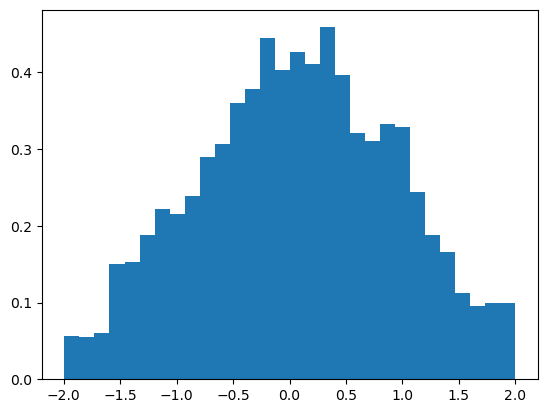

In [446]:
#y_hist is the density (pdf) of the posterior
nbins = 30
y_hist, x_hist, _ = plt.hist(C, bins = nbins, density=True)
density = ((bound-(-bound))/nbins)*y_hist
print(density.shape)

#check that the posterior iyntegrates to 1:
np.sum(density,axis=0)

In [448]:
#y_hist is the density (pdf) of the posterior
nbins = 30
y_hist, x_hist = np.histogram(C, bins = nbins, density=True)
density = ((bound-(-bound))/nbins)*y_hist
print(density.shape)

#check that the posterior iyntegrates to 1:
np.sum(density,axis=0)

(30,)


1.0015694210673745

## Implementing MCMC for 1D GPs

### a) Investigating 1 hyperparameter: $l$
Here, $\theta = \{l\}$ and we want to estimate the 1D posterior distribution $P(\theta)=p(\theta\vert X,y)$

From before, we have the unnormalized posterior of our GP as follows
$$
p(y\vert X,\theta)p(\theta) = \tilde{P}(\theta) = \left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y] \right)p(\theta)
$$
and note that
$$
\log(\tilde{P}(\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y + \log(p(\theta))
$$
<br>

For the purpose of example, say we only want to optimize the hyperparameter $l$, the lengthscale, giving us a 1D problem $\theta = l$.

Following the Metropolis-Hastings algorithm,

0) We set $l_0 = 0.75$. We choose $0.75$ because our $X$ is scaled to be between $0$ and $1$.
1) Choose a proposal distribution $Q(l_i'\vert l_{i-1}) \sim \text{Unif}(0, 10)$.
2) Since $Q$ is symmetric, our acceptance ratio is
$$
\alpha = T(l_{i}'\vert l_{i}) = \min\left[\frac{\tilde{P}(l_i')}{\tilde{P}(l_{i-1})} , 1 \right]
$$
For the purposes of numerical stability of the system's memory, we take the log of $\alpha$:
$$
\log(\alpha) = \min\left[\log(\tilde{P}(l_i')) - \log(\tilde{P}(l_{i-1})) , 0 \right]
$$
$$
= \min\left[\log\left(\left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y] \right)p(l_i')\right) - \log\left(\left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y] \right)p(l_{i-1})\right) , 0 \right]
$$
$$
= \min\left[\log\left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y]\right)_{l_i'} + \log(p(l_i')) - \log\left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y]\right)_{l_{i-1}} - \log(p(l_{i-1})), 0 \right]
$$
$$
= \min\left[\left(-\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y\right)_{l_i'} + \log(p(l_i')) - \left(-\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y\right)_{l_{i-1}} - \log(p(l_{i-1})), 0 \right]
$$
<br>

3) Generate a random uniform number $u_{i}\sim U(0,1)$.
4) If $u_i\leq \exp(\log(\alpha)) = \alpha$, accept the proposal by setting $l_i = l_i'$. Else, reject the proposal and set $l_i = l_{i-1}$.

**Previous method: Finite difference method with L-BFGS-B (variation of gradient-descent method)**

Number of iterations =  5
Min of obj funct =  -0.5013048936057842
sigma_n = 0.000100, l = 0.328095, sigma_f = 1.652056
Mean predictive std:  0.0015060928813231027


<Figure size 640x480 with 0 Axes>

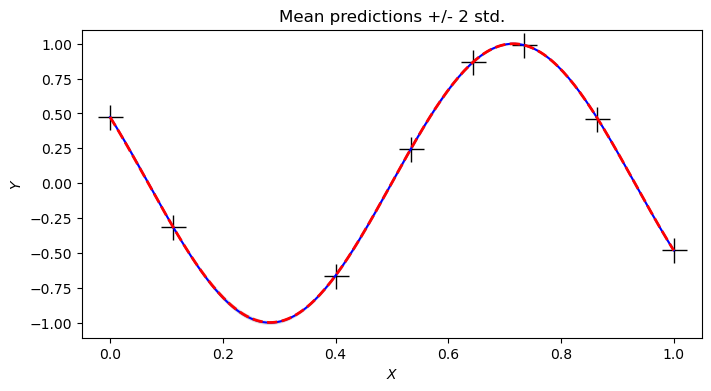

In [963]:
# Negative Marginal log-likelihood of the GP we would like to optimize (modified to allow focus on particular hyperparams)
def gp_loss_fn_focus(sigma_n, l, sigma, X, y): #input observations (X,y) and initial parameters (guess)
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #negative marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return mll #this is our objective function

#--------------
#Optimize l only

#Fix unwanted hyperparameters
sigma_n = init_par[0]
sigma = init_par[2]

#Define wrapper function to optimize l
def wrapper_l(l, X, y, sigma_n = sigma_n, sigma = sigma):
    return gp_loss_fn_focus(sigma_n, l, sigma, X, y)

#Initial guess for l
l0 = init_par[1]

opt_par = minimize(wrapper_l, l0, args=(X,y), method="L-BFGS-B", options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(init_par[0]), np.abs(opt_par.x[0]), np.abs(init_par[2]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

**MCMC method: Metropolis-Hastings from scratch**

In [964]:
#Marginal log-likelihood of the GP we would like to optimize (modified to allow focus on particular hyperparams)
def log_like(sigma_n, l, sigma, X, y): #input observations (X,y) and initial parameters (guess)
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return -1*mll
    
#-----------------
#MCMC MH implementation to optimize l only
#0) Initiation
a = 0.01
b = 10
N = 20000

#Define prior
def log_prior(l):
    if (l <= a or l >= b):
        value = 0.00001
    else:
        value = 1
    return np.log(value)

l = np.zeros(N)
l[0] = init_par[1]
accept_count = 0

#Fix unwanted hyperparameters
sigma_n = init_par[0]
sigma = init_par[2]

for i in range(1, N):
    #1) Propose new position l[i-1] -> l[i]' by sampling from proposal distro
    l_prop = np.random.uniform(a, b) #l[i]'
    #l_prop = stats.norm.pdf(l_prop, l[i-1], 1)/(stats.norm.cdf(b) - stats.norm.cdf(a))

    #2) Compute log of acceptance ratio
    prop = log_like(sigma_n, l_prop, sigma, X, y) + log_prior(l_prop)
    prev = log_like(sigma_n, l[i-1], sigma, X, y) + log_prior(l[i-1])
    
    log_alpha = min(prop - prev, 0)  # Acceptance ratio
    
    #3) Generate a random number u_i from [0,1]
    u = np.random.uniform(0,1) #u_i
    
    #4)
    if u <= np.exp(log_alpha):
        l[i] = l_prop  # Accept y as next state
        accept_count = accept_count + 1
    else:
        l[i] = l[i-1]  # Stay at previous state of Markov chain

n = int(0.95*N) #number of samples of the posterior
C = l[-n:]
print(len(C))
accept_rate = accept_count/N

C

19000


array([0.33306076, 0.33306076, 0.33306076, ..., 0.33111967, 0.33111967,
       0.33111967])

Mean acceptance rate:  0.007


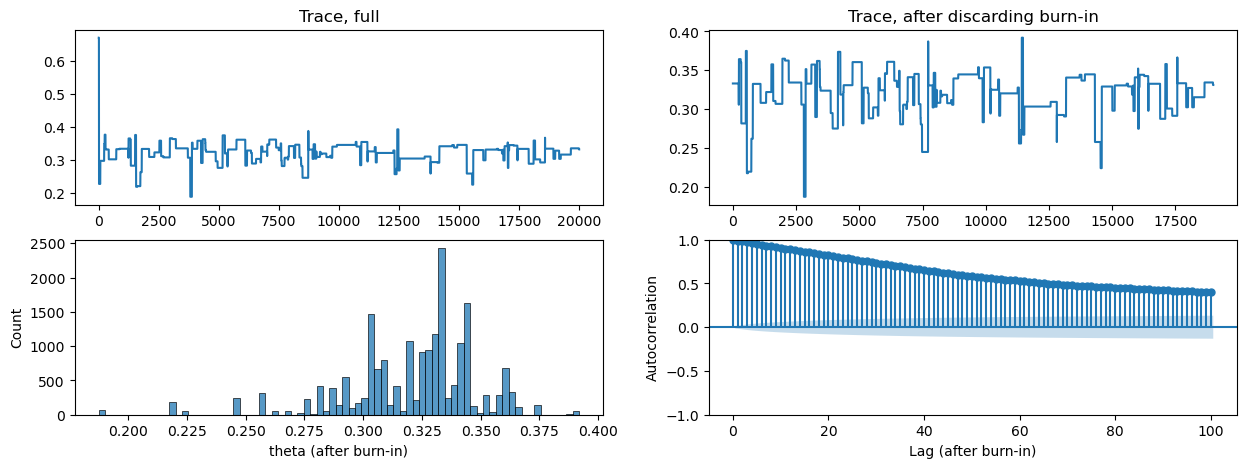

In [965]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_res(xs, burn_in, x_name):
    # plot trace (based on xs), distribution, and autocorrelation

    xs_kept = xs[burn_in:]
    
    # plot trace full
    fig, ax = plt.subplots(2,2, figsize=(15,5))
    ax[0,0].plot(xs)
    ax[0,0].set_title('Trace, full')
    
    # plot trace, after burn-in
    ax[0,1].plot(xs_kept)
    ax[0,1].set_title('Trace, after discarding burn-in')

    # plot distribution, after burn-in
    sns.histplot(xs_kept, ax=ax[1,0])
    ax[1,0].set_xlabel(f'{x_name} (after burn-in)')
    
    # plot autocorrelation, after burn-in
    plot_acf(np.array(xs_kept), lags=100, ax=ax[1,1], title='')
    ax[1,1].set_xlabel('Lag (after burn-in)')
    ax[1,1].set_ylabel('Autocorrelation')

    
plot_res(l, N-n, 'theta')
print(f"Mean acceptance rate: {accept_rate: .3f}")

Text(0, 0.5, 'l')

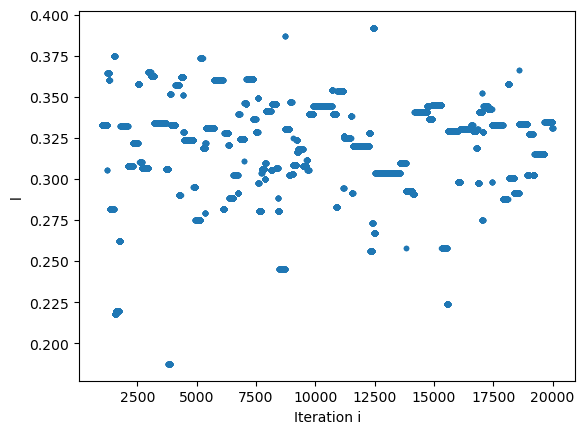

In [966]:
plt.plot(range(N-n, N),C,'.')
plt.xlabel('Iteration i')
plt.ylabel('l')

In [967]:
print("Mean of post of l: ", np.mean(C))
print("Std of post of l: ", np.std(C))
value = np.abs(C - np.mean(C))**2
np.sqrt(np.mean(value))

Mean of post of l:  0.3210711432409815
Std of post of l:  0.028385005463934212


0.028385005463934212

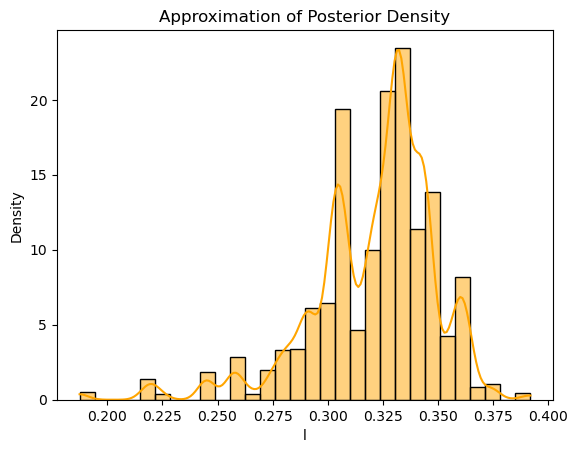

In [968]:
# Plot of MCMC approximation of the posterior
sns.histplot(C, kde=True, bins = 30, color="orange", stat="density")
plt.xlabel('l')
plt.title('Approximation of Posterior Density')
plt.show()

0.33059332017874077
0.0299396123692604


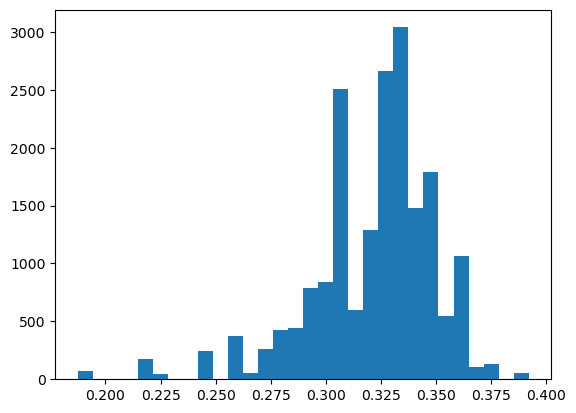

In [969]:
y_hist, x_hist, _ = plt.hist(C, bins = 30)
max_post_l = x_hist[np.where(y_hist == y_hist.max())][0]
#Maximum of posterior distribution: Maximum a posteriori estimation (MAP)
print(max_post_l)

#Standard devation around maximum of posterior distribution
value = np.abs(C - max_post_l)**2
max_std = np.sqrt(np.mean(value))
print(max_std)

In [970]:
#y_hist is the density (pdf) of the posterior
nbins = 30
y_hist, x_hist = np.histogram(C, bins = nbins, density=True)
density = ((np.max(C)-np.min(C))/nbins)*y_hist
print(density.shape)

#check that the posterior iyntegrates to 1:
np.sum(density,axis=0)

(30,)


0.9999999999999999

Using Maximum a posteriori (MAP). First plot has the actual true curve (blue), the posterior predictive mean (red), the posterior predictive error (grey shade), and the training points $X$ and $y$. The second plot samples $f_*\vert X,y$ from its posterior predictive distribution.

sigma_n = 0.000100, l = 0.330593, sigma_f = 1.652056
Mean predictive std:  0.001431086424188835


<Figure size 640x480 with 0 Axes>

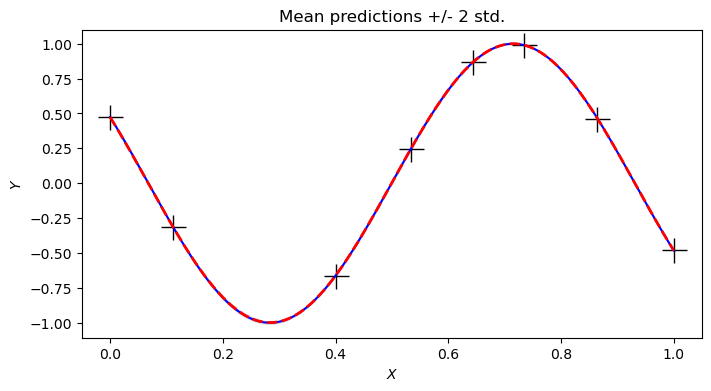

In [971]:
sigma_n, l, sigma = np.abs(init_par[0]), np.abs(max_post_l), np.abs(init_par[2])
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

<Figure size 640x480 with 0 Axes>

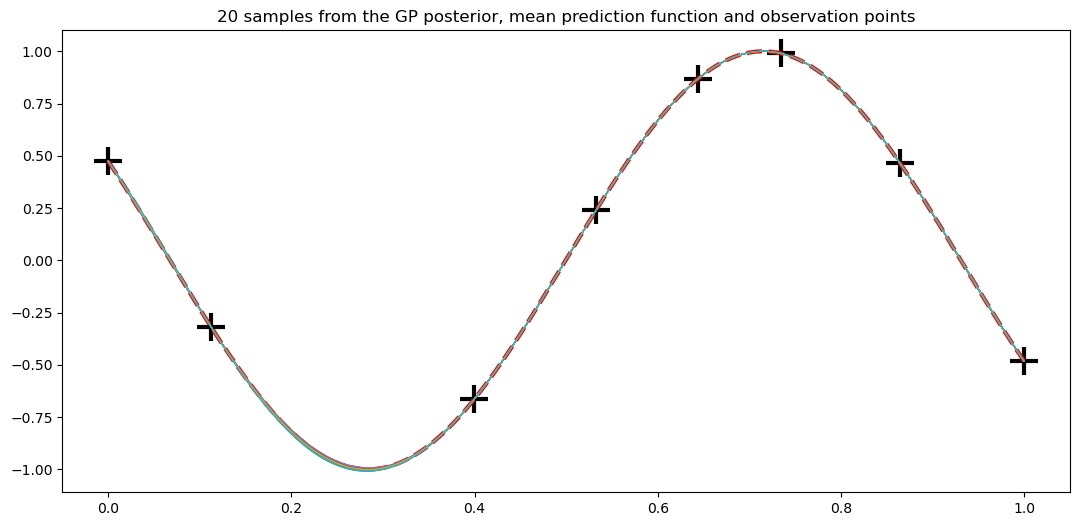

In [972]:
Xtest, mu, covar = posterior_full(X, y.T[0], sigma_n, l, sigma)
m = 20
f_post = np.random.multivariate_normal(mu,covar,20).T

## Plot of 40 samples from the GP posterior, along w
plt.clf()
plt.figure(figsize=(13,6))
#Plot training data:
plt.plot(X, y, 'k+', markersize=20, markeredgewidth=3)
#PLot predictive mean:
plt.plot(Xtest, mu, 'r--', linewidth=3)
#Plot samples from the GP posterior
plt.plot(Xtest, f_post, linewidth=0.8)
plt.title('20 samples from the GP posterior, mean prediction function and observation points')
plt.show()

#### Task 1: Propogation

**One test point**
We can use our posterior distribution to to create a predictive distribution of $f^*$ at a test location $x^*$, that is $f^*=f(x^*)$, by marginalizing the posterior. From before, recall that
\begin{equation}\label{eq4}
\begin{pmatrix} y \\ f_*\end{pmatrix} \sim N\left(\mathbf{0}, \begin{pmatrix}K + \sigma_n^2\mathbf{I} & K_* \\ K_*^T & K_{**}\end{pmatrix}\right)
\end{equation}

from which we can derive the conditional distribtuion and get the following posterior predictive distribution:
\begin{equation}\label{eq5}
	f_* \, \vert \, X, y, X_* \sim N \left(\bar{f}_*, cov(f_*)\right) 
\end{equation}
with the posterior mean
\begin{equation}\label{eq6}
	\bar{f}_* \overset{\Delta}{=} \mathbb{E} [\bar{f}_* \, \vert \, X, y, X_*] = K_*^T [K + \sigma_y^2\mathbf{I}]^{-1} y
\end{equation}
and the posterior variance
\begin{equation}\label{eq7}
	cov(f_*) = K_{**} - K_*^T [K + \sigma_y^2\mathbf{I}]^{-1} K_* 
\end{equation}

and we have our posterior distribution $p(\theta\vert y, X)$. Using the posterior and predictive distributions, we can create a distribution $p(f^*\vert X,y)$ of $f^*$ marginalized over $\theta$ giving us the marginal distribution
$$
p(f^*\vert X,y) = \int_a^b p(f^*\vert X,y,\theta)p(\theta\vert y,X)d\theta.
$$
We can see that the sampling distribution of $f^*$ is now a function of $\theta$, making it a likelihood, and the posterior $p(\theta\vert y,X)$ became a new prior (an example of a Bayesian update). We call $p(f^*\vert X,y)$ a posterior predictive distribution of a function $f^*$.

<br><br>
Sources used:
* https://arxiv.org/pdf/2305.11586

Xtest =  0.8 f(Xtest) =  0.815511869209005 mu_MAP =  0.8153776371522621 std_MAP =  0.0003537465862259929


Text(0, 0.5, 'Predictive Mean f*')

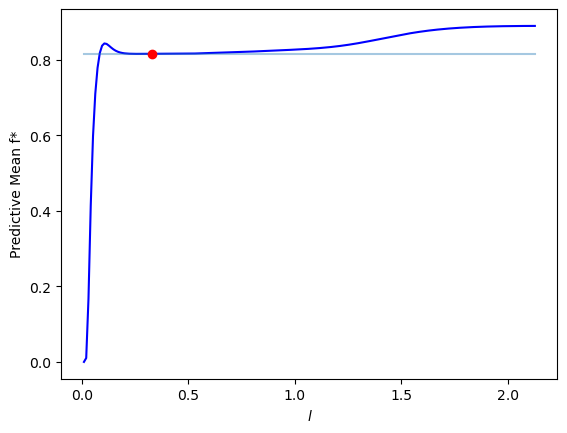

In [973]:
#Let's choose a test point
Xtest  = 0.8

sigma_n, l, sigma = np.abs(init_par[0]), np.abs(max_post_l), np.abs(init_par[2])
Xtest_val, mu_max, std_max = conditional(Xtest, X, y, sigma_n, l, sigma)
print('Xtest = ',Xtest_val,'f(Xtest) = ',f_scaled(Xtest,minX,maxX)[0],'mu_MAP = ',mu_max[0][0],'std_MAP = ',std_max[0])


#Sampling from the posterior +- 1std away from max:
post_values = np.linspace(a,max_post_l+60*max_std,200)
pred_means = []
for i in range(len(post_values)):
    sigma_n, l, sigma = np.abs(init_par[0]), np.abs(post_values[i]), np.abs(init_par[2])
    Xtest_val, mu, std = conditional(Xtest, X, y, sigma_n, l, sigma)
    pred_means.append(mu[0][0])

plt.plot(post_values,pred_means,'-',color='blue')
plt.plot(post_values,[f_scaled(Xtest,minX,maxX)[0]]*200,alpha=0.4) #actual value at that x*
plt.plot(max_post_l,mu_max[0][0],'ro') #MAP
plt.xlabel(r'$l$')
plt.ylabel('Predictive Mean f*')

Text(0, 0.5, 'Predictive Std')

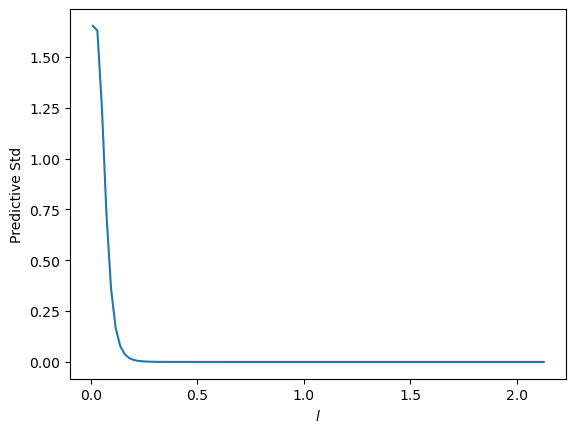

In [974]:
#Sampling from the posterior +- 1std away from max:
post_values = np.linspace(a,max_post_l+60*max_std,100)
pred_stds = []
for i in range(len(post_values)):
    sigma_n, l, sigma = np.abs(init_par[0]), np.abs(post_values[i]), np.abs(init_par[2])
    Xtest_val, mu, std = conditional(Xtest, X, y, sigma_n, l, sigma)
    pred_stds.append(std[0])

plt.plot(post_values,pred_stds,'-')
plt.xlabel(r'$l$')
plt.ylabel('Predictive Std')

Samples of $f^*$ from the predictive distributive $p(f^*\vert X,y)$.

In [975]:
nbins = 30
y_hist, x_hist = np.histogram(C, bins = nbins, density=True)
density_C = ((np.max(C)-np.min(C))/nbins)*y_hist #attempt at pdf of theta

def sample_pred(Xtest,X,y,sigma_n,l,sigma):
    Xtest, mu, covar = conditional_full(Xtest, X, y.T[0], sigma_n, l, sigma)
    ftest = np.random.multivariate_normal(mu, covar, 1000)
    return ftest#multivariate_normal.pdf(ftest,mu,covar)

def pdf_post(l):
    for i in range(nbins):
        if x_hist[i] <= l <= x_hist[i+1]:
            return density_C[i]
            break
        else:
            continue
            
def sample_pred_post(Xtest,X,y,sigma_n,sigma,density_C):
    integrands = []
    for i in range(nbins):
        integrand = sample_pred(Xtest,X,y,sigma_n,x_hist[i],sigma) * density_C[i]
        integrands.append(integrand)
        print(i,end="\r")
    return np.array(integrands)

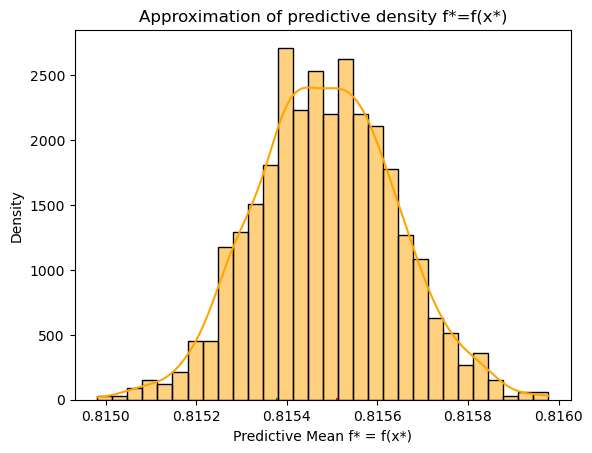

In [976]:
#Distribution of f* without marginalizing over the posterior of l:
l = 0.4
D = sample_pred(Xtest,X,y,sigma_n,l,sigma).T[0] 

plt.plot([f_scaled(Xtest,minX,maxX)[0]]*100,np.linspace(0,3,100),'r-') #actual
plt.plot([mu_max[0][0]]*100,np.linspace(0,3,100),'g-') #MAP
sns.histplot(D, kde=True, bins = 30, color="orange", stat="density")
plt.xlabel('f* = f(x*)')
plt.title('Approximation of predictive density f*=f(x*)')
plt.show()

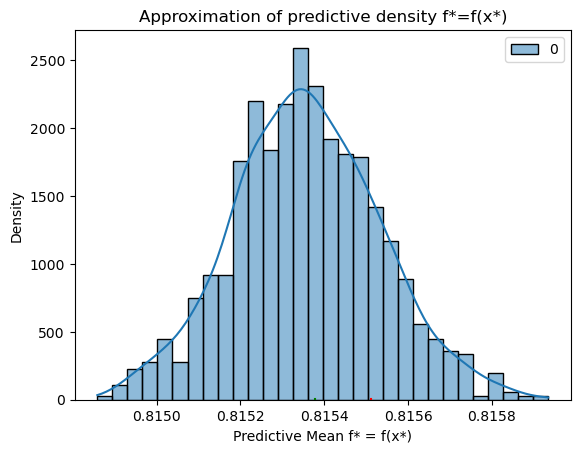

In [977]:
#Distribution of f* marginalized over the posterior of l:
E = np.sum(sample_pred_post(Xtest,X,y,sigma_n,sigma,density_C),axis=0)
E.shape

plt.plot([f_scaled(Xtest,minX,maxX)[0]]*100,np.linspace(0,3,100),'r-') #actual
plt.plot([mu_max[0][0]]*100,np.linspace(0,3,100),'g-') #MAP
sns.histplot(E, kde=True, bins = 30, color="orange", stat="density")
plt.xlabel('f* = f(x*)')
plt.title('Approximation of predictive density f*=f(x*)')
plt.show()

#### Task 2: Changing the prior